In [2]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items') # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Vishi.0000',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'D:/DA-ws/datasets/ecommerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [1]:
pip install mysql-connector-python

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mysql.connector
import os

conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Vishi.0000',
    database='ecommerce'
)
cursor = conn.cursor()

# 1. List all unique cities where customers are located.

In [6]:
query = """  SELECT distinct customer_city from customers """
cursor.execute(query)
data=cursor.fetchall()
data

[('franca',),
 ('sao bernardo do campo',),
 ('sao paulo',),
 ('mogi das cruzes',),
 ('campinas',),
 ('jaragua do sul',),
 ('timoteo',),
 ('curitiba',),
 ('belo horizonte',),
 ('montes claros',),
 ('rio de janeiro',),
 ('lencois paulista',),
 ('caxias do sul',),
 ('piracicaba',),
 ('guarulhos',),
 ('pacaja',),
 ('florianopolis',),
 ('aparecida de goiania',),
 ('santo andre',),
 ('goiania',),
 ('cachoeiro de itapemirim',),
 ('sao jose dos campos',),
 ('sao roque',),
 ('camacari',),
 ('resende',),
 ('sumare',),
 ('novo hamburgo',),
 ('sao luis',),
 ('sao jose',),
 ('santa barbara',),
 ('ribeirao preto',),
 ('ituiutaba',),
 ('taquarituba',),
 ('sao jose dos pinhais',),
 ('barrinha',),
 ('parati',),
 ('dourados',),
 ('trindade',),
 ('cascavel',),
 ('fortaleza',),
 ('brasilia',),
 ('pelotas',),
 ('porto alegre',),
 ('salto',),
 ('jundiai',),
 ('cacapava',),
 ('sao vicente',),
 ('uberlandia',),
 ('botelhos',),
 ('sao goncalo',),
 ('araucaria',),
 ('nova iguacu',),
 ('areia branca',),
 ('campo

# 2. Count the number of orders placed in 2017.

In [12]:
query = """  SELECT count(order_id) from orders where year(order_purchase_timestamp) =2017 """
cursor.execute(query)
data=cursor.fetchall()
"order placed in year 2017:",data[0][0]

('order placed in year 2017:', 45101)

# 3. Find the total sales per category. 

In [17]:
query = """  select upper(products.product_category) as Category,round(sum(payments.payment_value),2) as sales 
from products join order_items 
on products.product_id=order_items.product_id
join payments 
on payments.order_id=order_items.order_id 
group by product_category """
cursor.execute(query)
data=cursor.fetchall() 
df=pd.DataFrame(data,columns=["Category","Sales"])
df

,Category,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,FASHION BAGS AND ACCESSORIES,218158.28
4,BED TABLE BATH,1712553.67
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


# 4. Calculate the percentage of orders that were paid in installments.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mysql.connector
import os

conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Vishi.0000',
    database='ecommerce'
)
cursor = conn.cursor()


In [3]:
query = """ select (sum(case when payment_installments>1 then 1 
else 0 end))/count(*) *100 as installment_percentage from payments """
cursor.execute(query)
data=cursor.fetchall() 
data


[(Decimal('49.4176'),)]

# 5. Count the number of customers from each state

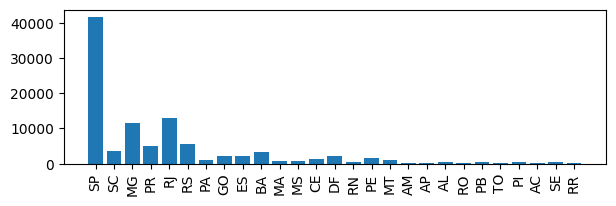

In [10]:
query = """ select customer_state,count(customer_id) from customers group by customer_state """
cursor.execute(query)
data=cursor.fetchall() 
plt.figure(figsize =(7,2))
df=pd.DataFrame(data, columns=["State","customers"])
plt.bar(df["State"],df["customers"])
plt.xticks(rotation = 90)
plt.show()


In [ ]:
                                                        #intermediate queries

# Calculate the number of orders per month in 2018.

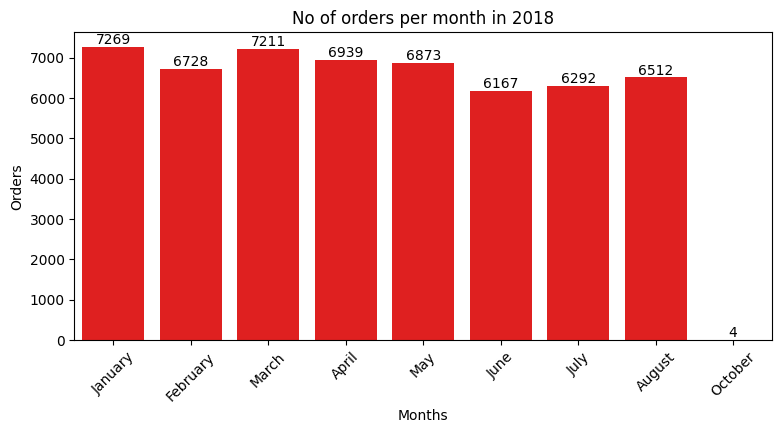

In [20]:
query = """ select monthname(order_purchase_timestamp) month,count(order_id) orders from orders where year(order_purchase_timestamp)=2018 group by monthname(order_purchase_timestamp) """
cursor.execute(query)
data=cursor.fetchall() 
plt.figure(figsize =(9,4))
df=pd.DataFrame(data, columns=["Months","Orders"], )
o = ["January","February","March","April","May","June","July","August","October"]
ax=sns.barplot(x= df["Months"], y= df["Orders"], data=df, order= o, color="red")
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("No of orders per month in 2018")
plt.show()


# Find the average number of products per order, grouped by customer city.

In [25]:
query = """ with count_per_order as
(select orders.order_id,orders.customer_id,count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id,orders.customer_id)

select customers.customer_city,round(avg(count_per_order.oc),2) as average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city """
cursor.execute(query)
data=cursor.fetchall() 
df=pd.DataFrame(data,columns=["City","Avg counnt"])
df.head(10)


,City,Avg counnt
0,sao jose dos campos,1.14
1,indaial,1.12
2,treze tilias,1.27
3,sao paulo,1.16
4,rio de janeiro,1.15
5,mario campos,1.33
6,guariba,1.00
7,cuiaba,1.20
8,franca,1.25
9,tocos,1.00


# Calculate the percentage of total revenue contributed by each product category.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mysql.connector
import os

conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Vishi.0000',
    database='ecommerce'
)
cursor = conn.cursor()


In [3]:
query = """ select upper(products.product_category) as category,
round((sum(payments.payment_value)/(select sum(payment_value) from payments as sales))*100,2) sales
from products join order_items 
on products.product_id=order_items.product_id
join payments 
on payments.order_id=order_items.order_id 
group by category order by sales desc;"""
cursor.execute(query)
data=cursor.fetchall() 
df=pd.DataFrame(data,columns=["Category","Percentage"])
df

,Category,Percentage
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93
...,...,...
69,HOUSE COMFORT 2,0.01
70,CDS MUSIC DVDS,0.01
71,PC GAMER,0.01
72,FASHION CHILDREN'S CLOTHING,0.00


# Identify the correlation between product price and the number of times a product has been purchased.

In [7]:
import numpy as np
query = """ select products.product_category,count(order_items.product_id),round(avg(order_items.price),2) as avg_price
from products join order_items
on products.product_id=order_items.product_id
group by products.product_category """
cursor.execute(query)
data=cursor.fetchall() 
df=pd.DataFrame(data,columns=["Category","order_count","price"])

arr1=df["order_count"]
arr2=df["price"]
a=np.corrcoef([arr1,arr2])
print("the correlation bw pp and no of times of prod purchase is ",a[0][1])

the correlation bw pp and no of times of prod purchase is  -0.10631514167157562


#  Calculate the total revenue generated by each seller, and rank them by revenue.

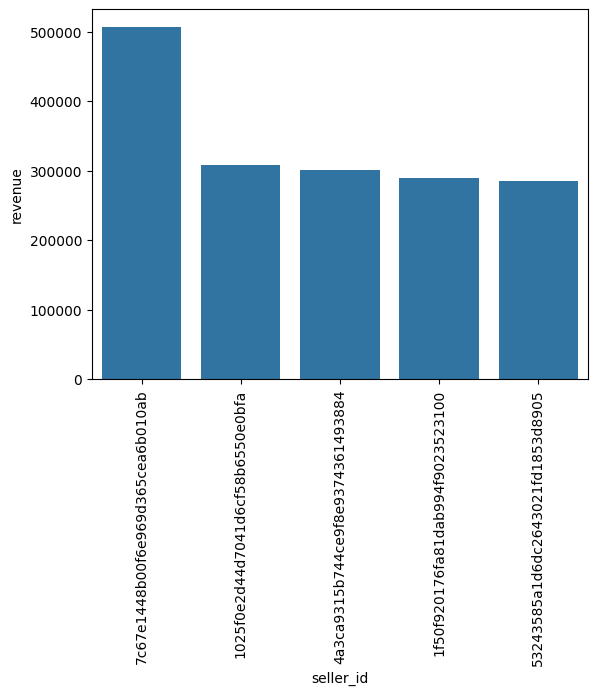

In [6]:
query = """ select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a """

cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
df = df.head()
sns.barplot(x = "seller_id", y = "revenue", data = df)
plt.xticks(rotation = 90)
plt.show()

In [ ]:
                                                     #advanced

# Calculate the moving average of order values for each customer over their order history.

In [2]:
query = """ select  customer_id,order_purchase_timestamp,payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg from
(select orders.customer_id,orders.order_purchase_timestamp,
payments.payment_value as payment
from orders join payments
on orders.order_id=payments.order_id) as a """
cursor.execute(query)
data=cursor.fetchall() 
df=pd.DataFrame(data,columns=["Customer_id","timestamp","pricce","mov_avg"])


,Customer_id,timestamp,pricce,mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


In [7]:
query = """ select years,months, sum(payment) over(order by years,months) cumsales from
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment
from orders join payments 
on orders.order_id=payments.order_id
group by years,months order by years,months) as a """
cursor.execute(query)
data=cursor.fetchall() 
df=pd.DataFrame(data,columns=["years","months","cumsales"])
df.head(15)

,years,months,cumsales
0,2016,9,252.24
1,2016,10,59342.72
2,2016,12,59362.34
3,2017,1,197850.38
4,2017,2,489758.39
5,2017,3,939621.99
6,2017,4,1357410.02
7,2017,5,1950328.84
8,2017,6,2461605.22
9,2017,7,3053988.14


#  Calculate the year-over-year growth rate of total sales

In [2]:
query = """ with a as (select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment
from orders join payments 
on orders.order_id=payments.order_id
group by years order by years)
select years,payment,round(((payment-lag(payment,1) over(order by years))/lag(payment,1) over(order by years)*100),3) 
yoygrowth from a """
cursor.execute(query)
data=cursor.fetchall() 
df=pd.DataFrame(data,columns=["Years","Total_sales","yoy_Growth"])
df

,Years,Total_sales,yoy_Growth
0,2016,59362.34,NaN
1,2017,7249746.73,12112.704
2,2018,8699763.05,20.001


#  Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase

In [8]:
query = """ with a as (select customers.customer_id,min(orders.order_purchase_timestamp) first_order
from customers join orders 
on customers.customer_id=orders.customer_id
group by customers.customer_id),
b as(select a.customer_id,count(distinct orders.order_purchase_timestamp)
from a join orders
on a.customer_id=orders.customer_id
and orders.order_purchase_timestamp> first_order and
orders.order_purchase_timestamp > date_add(first_order, interval 6 month)
group by a.customer_id)
select 100* (count(distinct a.customer_id)/count(distinct b.customer_id))
from a left join b
on a.customer_id=b.customer_id """
cursor.execute(query)
data=cursor.fetchall() 
data

[(None,)]

# Identify the top 3 customers who spent the most money in each year.

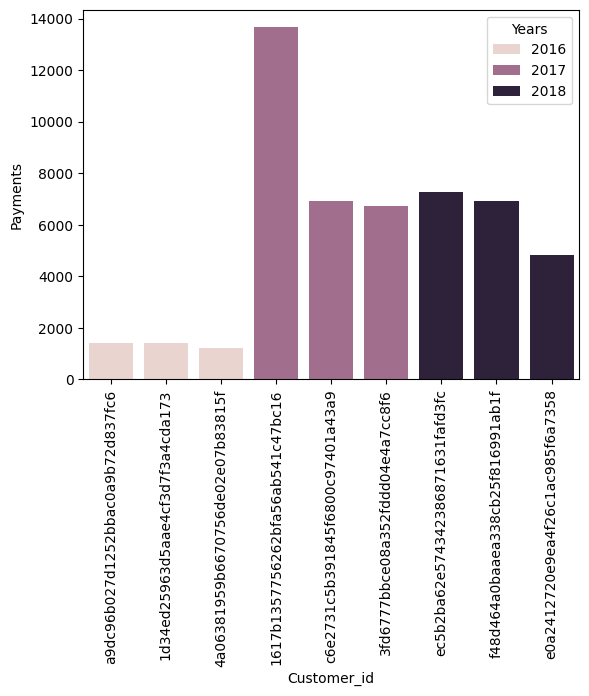

In [10]:
query=""" select years,customer_id,payment,d_rank from 
(select year(orders.order_purchase_timestamp) years,orders.customer_id,sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp) order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on orders.order_id=payments.order_id
group by year(orders.order_purchase_timestamp),orders.customer_id) as a 
where d_rank<=3 """
cursor.execute(query)
data=cursor.fetchall() 
df=pd.DataFrame(data,columns=["Years","Customer_id","Payments","Rank"])
sns.barplot(x="Customer_id", y= "Payments", data=df, hue="Years")
plt.xticks(rotation=90)
plt.show()
